Rebalance date: 2019-04-03
Selected tickers: ['MRK', 'XOM', 'PEP', 'GOOG', 'BRK-B', 'NVDA', 'MA', 'MSFT', 'UNH', 'AAPL', 'PG', 'META', 'JNJ', 'NFLX', 'TSLA']
Weights:
MRK      0.067
XOM      0.067
PEP      0.067
GOOG     0.067
BRK-B    0.067
NVDA     0.067
MA       0.067
MSFT     0.067
UNH      0.067
AAPL     0.067
PG       0.067
META     0.067
JNJ      0.067
NFLX     0.067
TSLA     0.067
dtype: float64
Explained variance (first 3 PCs): [0.41404474 0.13107155 0.07413406]
----------------------------------------
Rebalance date: 2019-07-03
Selected tickers: ['MRK', 'PEP', 'XOM', 'COST', 'BRK-B', 'JNJ', 'MA', 'AMZN', 'UNH', 'CVX', 'META', 'GOOG', 'TSLA', 'ABBV']
Weights:
MRK      0.071
PEP      0.071
XOM      0.071
COST     0.071
BRK-B    0.071
JNJ      0.071
MA       0.071
AMZN     0.071
UNH      0.071
CVX      0.071
META     0.071
GOOG     0.071
TSLA     0.071
ABBV     0.071
dtype: float64
Explained variance (first 3 PCs): [0.38635942 0.10689581 0.08922854]
-----------------------------

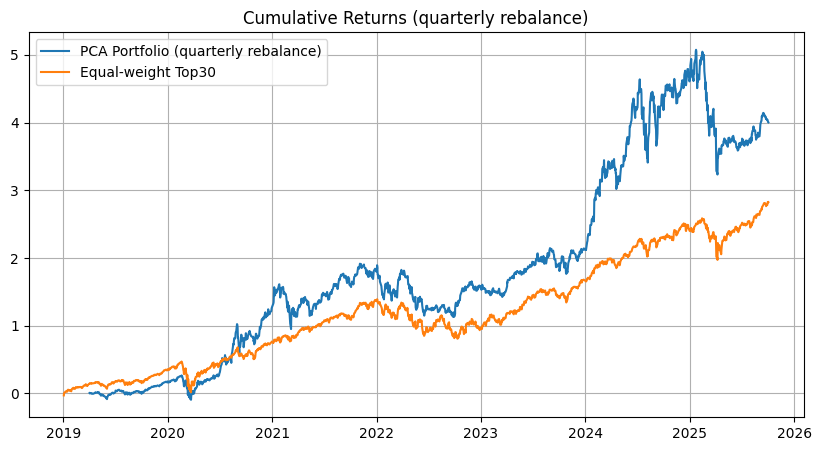

Done.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from datetime import datetime


TOP30_TICKERS = [
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "META", "BRK-B", "GOOG", "LLY", "JPM",
    "AVGO", "TSLA", "UNH", "V", "XOM", "JNJ", "WMT", "PG", "MA", "HD",
    "CVX", "MRK", "ABBV", "COST", "PEP", "BAC", "KO", "NFLX", "ADBE", "ASML"
]

# -----------------------
# 1) Загружаем цены
# -----------------------

def download_prices(tickers, start_date='2019-01-01', end_date=None):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    data = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker', auto_adjust=True)
    # handle multiindex columns
    if isinstance(data.columns, pd.MultiIndex):
        data = data.loc[:, (slice(None), 'Close')]
        data.columns = [col[0] for col in data.columns]
    else:
        data = data[['Close']]
    data = data.dropna(axis=1, how='any')
    return data

# -----------------------
# 2) Считаем логарифмическую доходность
# -----------------------

def compute_log_returns(prices):
    r = np.log(prices).diff().dropna()
    r = r.ffill().bfill()
    return r

# -----------------------
# 3) Сигналы: momentum, short-term, quality
# -----------------------

def compute_signals(prices, returns):
    lookback_12m = 252
    skip = 21
    mom_skip = (prices / prices.shift(lookback_12m + skip)) - 1
    mom_signal = mom_skip.iloc[-1]
    mom3_signal = (prices / prices.shift(63) - 1).iloc[-1]
    quality = 1 / returns.std()
    def zscore(s): return (s - s.mean()) / (s.std() + 1e-12)
    mom_z, mom3_z, qual_z = zscore(mom_signal), zscore(mom3_signal), zscore(quality)
    score = 0.6*mom_z + 0.2*mom3_z + 0.2*qual_z
    return pd.DataFrame({'momentum12_z': mom_z, 'momentum3_z': mom3_z, 'quality_z': qual_z, 'score': score})

# -----------------------
# 4) PCA  covariance
# -----------------------

def cov_and_pca(returns, n_components=None):
    R = returns - returns.mean()
    lw = LedoitWolf().fit(R.values)
    cov = lw.covariance_
    if n_components is None:
        n_components = min(10, R.shape[1])
    pca = PCA(n_components=n_components)
    pca.fit(R.values)
    components = pd.DataFrame(pca.components_.T, index=returns.columns, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])])
    return cov, components, pca.explained_variance_ratio_

# -----------------------
# 5) Группируем доминирующие факторы
# -----------------------

def group_and_select(comp_df, score_df, top_per_group=2):
    dominant = comp_df.abs().idxmax(axis=1)
    groups = {}
    for g in dominant.unique():
        members = dominant[dominant==g].index.tolist()
        s = score_df.loc[members, 'score'].sort_values(ascending=False)
        groups[g] = s.head(top_per_group).index.tolist()
    selected_list = [v for vals in groups.values() for v in vals]
    seen = set(); sel_unique = [x for x in selected_list if not (x in seen or seen.add(x))]
    return sel_unique, groups

# -----------------------
# 6) Считаем веса по формуле: score / volatility
# -----------------------

def compute_weights(selected, score_df, returns, max_weight=0.4):
    vol = returns[selected].std()
    sc = score_df.loc[selected, 'score']
    pre = sc.abs()/vol
    pre[sc<0] = 0
    if pre.sum()==0: w = pd.Series(1/len(selected), index=selected); return w
    w = pre / pre.sum()
    w = w.clip(upper=max_weight)
    return w / w.sum()

# -----------------------
# 7) Backtest
# -----------------------

def backtest_hold(weights, prices):
    r = np.log(prices[weights.index]).diff().dropna()
    rp = (r*weights).sum(axis=1)
    cum = np.exp(rp.cumsum())-1
    return rp, cum

# -----------------------
# 8) Full pipeline
# -----------------------

def run_pipeline_quarterly(start_date='2019-01-01', rebalance_months=3, top_per_group=2):
    prices = download_prices(TOP30_TICKERS, start_date=start_date)
    returns = compute_log_returns(prices)

    all_rp = []
    all_dates = []
    last_date = returns.index[0]

    while last_date < returns.index[-1]:
        next_date = last_date + pd.DateOffset(months=rebalance_months)
        if next_date > returns.index[-1]:
            next_date = returns.index[-1]
        sub_prices = prices.loc[:last_date]
        sub_returns = returns.loc[:last_date]

        if sub_returns.shape[0] < 20 or sub_returns.shape[1] < 2:
            last_date = next_date
            continue
        scores = compute_signals(sub_prices, sub_returns)
        n_components = min(8, sub_returns.shape[1], len(sub_returns))
        cov, comp_df, explained = cov_and_pca(sub_returns, n_components=n_components)
        selected, groups = group_and_select(comp_df, scores, top_per_group=top_per_group)
        weights = compute_weights(selected, scores, sub_returns, max_weight=0.4)
        print("Rebalance date:", last_date.strftime('%Y-%m-%d'))
        print("Selected tickers:", selected)
        print("Weights:")
        print(weights.round(3))
        print("Explained variance (first 3 PCs):", explained[:3])
        print("----------------------------------------")

        period_rets = returns.loc[last_date:next_date, weights.index]
        rp = (period_rets * weights).sum(axis=1)

        all_rp.append(rp)
        all_dates.append(rp.index)

        last_date = next_date

    rp_all = pd.concat(all_rp).sort_index()
    cum = np.exp(rp_all.cumsum()) - 1

    bench_weights = pd.Series(1/len(TOP30_TICKERS), index=TOP30_TICKERS)
    _, bench_cum = backtest_hold(bench_weights, prices)

    plt.figure(figsize=(10,5))
    plt.plot(cum.index, cum.values, label='PCA Portfolio (quarterly rebalance)')
    plt.plot(bench_cum.index, bench_cum.values, label='Equal-weight Top30')
    plt.title('Cumulative Returns (quarterly rebalance)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return cum, bench_cum


if __name__=='__main__':
    out = run_pipeline_quarterly(start_date='2019-01-01')
    print('Done.')